In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [3]:
# sets a specific gpu
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
# this will be your trained model instead
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
model = VGG16(
    weights='imagenet'
)
# model.summary()

In [5]:
# only the partial model is needed for the visualizers
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
#select only one from your list
example_id = 0

# image folder
path = "data/images/"

In [7]:
# change this to load a list of images you want
orig_imgs = [img_to_array(load_img("data/images/example.jpg", target_size=(224, 224)))] 
input_imgs = np.copy(orig_imgs)
print(np.shape(input_imgs))

# preprocess input for model
input_imgs = preprocess_input(input_imgs) #for built in keras models

(1, 224, 224, 3)


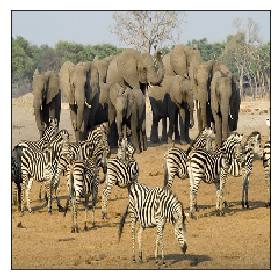

In [8]:
plt.imshow(orig_imgs[example_id].astype(int))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

max_input = input_imgs.max()  # x_test.max()
min_input = input_imgs.min()  # x_test.min()

In [9]:
target_class = 340

In [10]:
# optional
predictions = model.predict(input_imgs)
pred_id = np.argmax(predictions[example_id])
print(decode_predictions(predictions))
print("prediction id:", pred_id)
print("target id:", target_class)

[[('n02391049', 'zebra', 0.9992812), ('n01518878', 'ostrich', 0.00030275556), ('n02437312', 'Arabian_camel', 0.00014217419), ('n02422699', 'impala', 0.00012684488), ('n02423022', 'gazelle', 0.00011735329)]]
prediction id: 340
target id: 340


# GradCAM

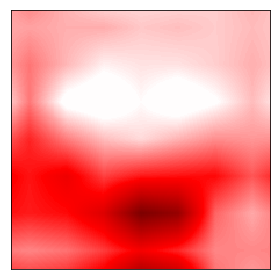

In [11]:
# target layer is the layer you want to target
target_layer = "block5_pool" #vgg only

partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(input_imgs)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

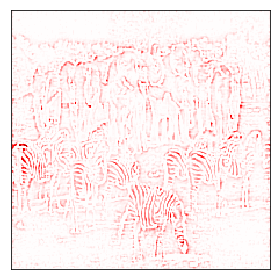

In [12]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=True,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(input_imgs)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

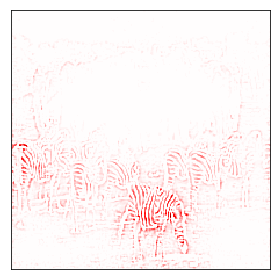

In [13]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    relu=True,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(input_imgs)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

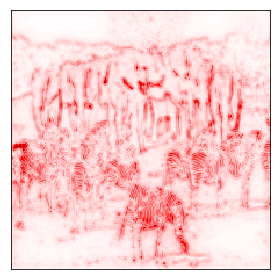

In [14]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

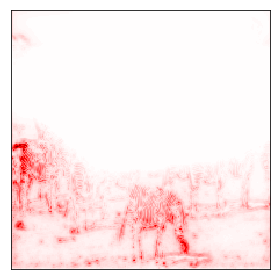

In [15]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

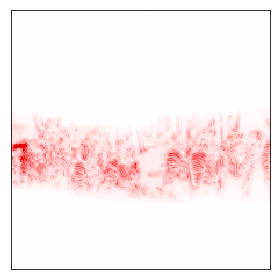

In [16]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()